In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from utils.angle_data import AngleData, SingleRun, get_data
# from utils import fresnel

from iminuit import Minuit, minuit

import matplotlib as mplhep

from utils.style import make_style
make_style()

import glob

In [2]:
plt.rcParams['figure.dpi'] = 150
import mplhep as hep

In [3]:
def r_12_p(theta, n1, n2):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    return (
        (n2 * np.cos(theta) - n1 * cos_theta2) / (n1 * cos_theta2 + n2 * np.cos(theta))
    )

def r_12_s(theta, n1, n2):
    '''Compute r_s fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    return (
        (n1 * np.cos(theta) - n2 * cos_theta2) / (n1 * np.cos(theta) + n2 * cos_theta2)
    )

def r_23_p(theta, n1, n2, n3):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    cos_theta3 = np.sqrt(1 - ((n1/n3) * np.sin(theta))**2)
    return (
        (n3 * cos_theta2 - n2 * cos_theta3) / (n3 * cos_theta2 + n2 * cos_theta3)
    )

def r_23_s(theta, n1, n2, n3):
    '''Compute r_s fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    cos_theta3 = np.sqrt(1 - ((n1/n3) * np.sin(theta))**2)
    return (
        (n2 * cos_theta2 - n3 * cos_theta3) / (n2 * cos_theta2 + n3 * cos_theta3)
    )
    
def phi(theta, ni, nt, d): 
    cos_transmitted = np.sqrt(1 - ((ni/nt) * np.sin(theta))**2)
    return 2 * np.pi * d * nt/ 532 * cos_transmitted
    
def construct_three_layer_r(r_al: callable, r_ls: callable, theta, n1, n2, n3, d):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    `n3`: complex refractive indices for material 3 (n = n + k*1j)
    `d` : inner layer width
    '''
    
    return (
        (r_al(theta, n1, n2) + r_ls(theta, n1, n2, n3) * np.exp(2j * phi(theta, n1, n2, d)))/
        (1 + r_al(theta, n1, n2) * r_ls(theta, n1, n2, n3) * np.exp(2j * phi(theta, n1, n2, d)))
    )


def Si_Rs(theta, n1, n2, n3, d, phase):
    rs_tot = construct_three_layer_r(r_12_s, r_23_s, theta - phase, n1, n2, n3, d)
    return np.abs( rs_tot * np.conj(rs_tot) )

def Si_Rp(theta, n1, n2, n3, d, phase):
    rp_tot = construct_three_layer_r(r_12_p, r_23_p, theta - phase, n1, n2, n3, d)
    return np.abs( rp_tot * np.conj(rp_tot) )


# Problemi con il fit

Abbiamo costruito la funzione di fit combinando le due funzioni, ovvero $$fcn = \sum_{i,\mathrm{R_s}}\left(\frac{(y_{i,\mathrm{R_s}} - f_1(x_i))^2}{\sigma_{i,\mathrm{R_s}}^2}\right) + \sum_{i,\mathrm{R_p}}\left(\frac{(y_{i,\mathrm{R_p}} - f_1(x_i))^2}{\sigma_{i,\mathrm{R_s}}^2}\right)$$

In questo modo però non otteniamo un risultato efficace.
Combinando così il chi$^2$ osserviamo che fnc=3800 circa, mentre eseguendo il fit singolarmente per le due funzioni avremo invece che questo risulta essere differente nei due casi. 

In [143]:
Si_s_adl = get_data(sorted(glob.glob('../data/dataSi_0/**.lvm')), 23)
Si_p_adl = get_data(sorted(glob.glob('../data/dataSi_1/**.lvm')), 23)

p_Si = SingleRun(Si_p_adl, Si_p_adl[-1])
s_Si = SingleRun(Si_s_adl, Si_s_adl[-1])

# p_Si.reflectance_std += (0.01)

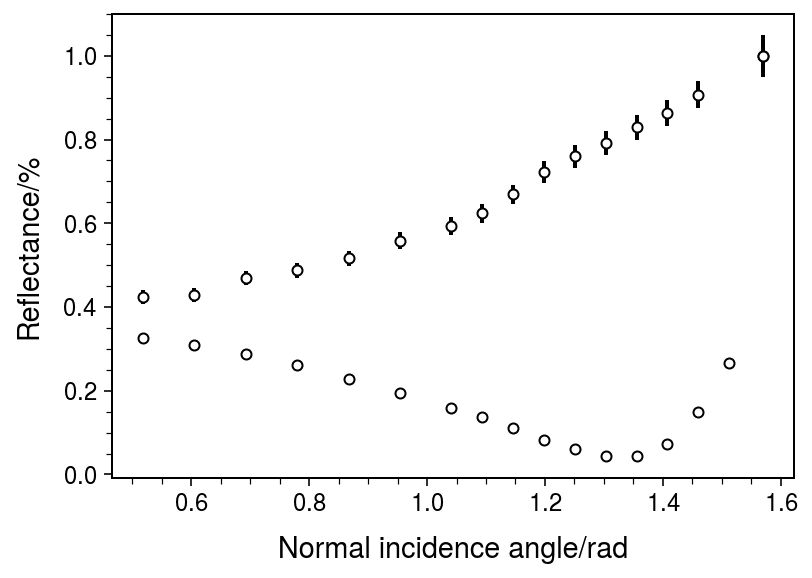

In [144]:
p_Si.plot()
s_Si.plot()

Come vorrei procedere:
 - Ottenere il fit combinato con la funzione riportata sopra, descrivendo bene quali sono i parametri che si sono fissati. Ottenere rispetto a tutti i parametri di fit curve di livello della minimizzazione. 
 - Ottenere il fit separato per $R_s$ e per $R_p$, considerare anche in questo caso tutti i parametri minimizzati e vedere come sono le curve di livello
     - comparare in questo caso anche il valore della funzione, eventualmente verificare che le normalizzzazioni non hanno senso
 - Ottenere il _fit dei poveri_ mettendo le funzioni in ordine e costruendo una funzione per punti (con delle theta di H), per verificare in questo modo che aspetto ha stacazzo di funzione. 
 - Verificare in tutti i casi compatibilità dei parametri stimati. 


In [145]:
from jacobi import propagate

def CLs_plot(m: Minuit, model: callable, cx, parameters, color):
    y, ycov = propagate(lambda p: model(cx, p), m.values, m.covariance)
    plt.plot(cx,y,color=color)
    yerr_prop = np.diag(ycov) ** 0.5
    plt.fill_between(cx, y - yerr_prop, y + yerr_prop, facecolor=color, alpha=0.5)

In [146]:
from iminuit.cost import LeastSquares

parameters = [
    1.00027821,  # n_Air  
    0,
    1.4607,      # n_SiO2 
    0,
    4.1360,      # n_Si   
    0.010205,    # k_Si   
    2,
    0,
]


n_Air  = 1.00027821
n_SiO2 = 1.4607
n_Si = 4.1360
k_Si = 0.010205

model_Rp = lambda x, p: Si_Rp(x, p[0]+1j*p[1], p[2]+1j*p[3], p[4]+1j*p[5],p[6],p[7])
model_Rs = lambda x, p: Si_Rs(x, p[0]+1j*p[1], p[2]+1j*p[3], p[4]+1j*p[5],p[6],p[7])

In [173]:
def p_plot(m_Rp: Minuit, m_Rs: Minuit):
    
    names = [
        '$n_\mathrm{Air}$',
        '$\kappa_\mathrm{Air}$',
        '$n_\mathrm{SiO_2}$',
        '$\kappa_\mathrm{SiO_2}$',
        '$n_\mathrm{Si}$',
        '$\kappa_\mathrm{Si}$',
        '$d$',
        '$\phi$'
    ]
    
    i = 0
    
    fig, axs = plt.subplots(8, 1,figsize=(5, 10))
    fig.tight_layout()
    
    for val_Rp, std_Rp, val_Rs, std_Rs in zip(m_Rp.values, m_Rp.errors, m_Rs.values, m_Rs.errors):
        axs[i].errorbar(val_Rp, 0.05, xerr=std_Rp, 
                        color='r', ecolor='r', fmt='o', mfc='w', label='$\chi^2_\mathrm{R_p}$ model')
        axs[i].errorbar(val_Rs, -0.05, xerr=std_Rs, 
                        color='b', ecolor='b', fmt='o', mfc='w', label='$\chi^2_\mathrm{R_s}$ model')
        axs[i].set_yticks([0], [names[i]])
        axs[i].set_ylim(-0.2,0.2)
        axs[i].set_title(f'NIST value {parameters[i]}')        
        i += 1
    plt.legend(frameon=False,loc=(1.2, 0))

## Fit combinato

Definiamo una distribuzione combinata (non normalizzata) del chi$^2$ come $\chi^2 = \chi^2_{R_p} + \chi^2_{R_s}$, e minimizziamo.

In [148]:
fcn = LeastSquares(s_Si.angles, s_Si.reflectance, s_Si.reflectance_std, model_Rs) + LeastSquares(p_Si.angles, p_Si.reflectance, p_Si.reflectance_std, model_Rp)
CommRRC2MM = Minuit(fcn, parameters)

In [149]:
CommRRC2MM.fixed[0] = True
CommRRC2MM.fixed[1] = True
# CommRRC2MM.fixed[2] = True
CommRRC2MM.fixed[3] = True
# CommRRC2MM.fixed[4] = True
# CommRRC2MM.fixed[5] = True
# CommRRC2MM.fixed[7] = True

In [150]:
CommRRC2MM.migrad()
CommRRC2MM.hesse()
CommRRC2MM.migrad()
CommRRC2MM.migrad()
CommRRC2MM.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3761 (chi2/ndof = 134.3)   │             Nfcn = 1278              │
│ EDM = 2.5e-09 (Goal: 0.0002)     │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 1 │ x1   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ x2   │  1.01498  │  0.00008  │            │            │         │         │       │
│ 3 │ x3   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 4 │ x4   │  4.0824   │  0.0020   │            │            │         │         │       │
│ 5 │ x5   │   0.850   │   0.005   │            │            │         │         │       │
│ 6 │ x6   │   202.6   │    0.9    │            │            │         │         │       │
│ 7 │ x7   │ 0.045e-3  │ 0.025e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7 │
├────┼─────────────────────────────────────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0         0         0         0 │
│ x1 │         0         0         0         0         0         0         0         0 │
│ x2 │         0         0  6.49e-09         0   1.1e-07 -2.94e-07 -5.15e-05  -1.7e-10 │
│ x3 │         0         0         0         0         0         0         0         0 │
│ x4 │         0         0   1.1e-07         0  3.82e-06 -8.89e-06 -0.000274 -1.04e-08 │
│ x5 │         0         0 -2.94e-07         0 -8.89e-06  2.22e-05  0.000746  1.74e-08 │
│ x6 │         0         0 -5.15e-05         0 -0.000274  0.000746     0.851 -1.02e-06 │
│ x7 │         0         0  -1.7e-10         0 -1.04e-08  1.74e-08 -1.02e-06   6.2e-10 │
└────┴─────────────────────────────────────────────────────────────────────────────────┘

In [151]:
angles = np.linspace(np.pi/7, np.pi/2, 500)

nAir, kAir, nSiO2, kSiO2, nSi, kSi, d, ϕ = CommRRC2MM.values
nAir_std, kAir_std, nSiO2_std, kSiO2_std, nSi_std, kSi_std, d_std, ϕ_std = CommRRC2MM.errors

res_RS_TH = Si_Rs(angles, n_Air, n_SiO2, n_Si+k_Si*1j, 2, 0) - Si_Rs(angles, nAir, nSiO2, nSi+kSi*1j, d, ϕ)
res_RS_DP = s_Si.reflectance - Si_Rs(s_Si.angles, nAir, nSiO2, nSi+kSi*1j, d, ϕ)

res_RP_TH = Si_Rp(angles, n_Air, n_SiO2, n_Si+k_Si*1j, 2, 0) - Si_Rp(angles, nAir, nSiO2, nSi+kSi*1j, d, ϕ)
res_RP_DP = p_Si.reflectance - Si_Rp(p_Si.angles, nAir, nSiO2, nSi+kSi*1j, d, ϕ)

In [152]:
import hist

res_RSH = hist.Hist(hist.axis.Regular(5, res_RS_DP.min(), res_RS_DP.max()))
res_RSH.fill(res_RS_DP)

Hist(Regular(5, -0.0143535, 0.0552025, label='Axis 0'), storage=Double()) # Sum: 15.0 (16.0 with flow)

In [158]:
res_RPH = hist.Hist(hist.axis.Regular(25, res_RP_DP.min(), res_RP_DP.max()))
res_RPH.fill(res_RP_DP)

Hist(Regular(25, -0.116449, 0.00387761, label='Axis 0'), storage=Double()) # Sum: 16.0 (17.0 with flow)

In [159]:
def sigma_from_residuals(residuals):
    return np.sqrt(np.sum(residuals**2)/(len(residuals) - 2))

error_RS_scale = sigma_from_residuals(res_RS_DP)
error_RP_scale = sigma_from_residuals(res_RP_DP)

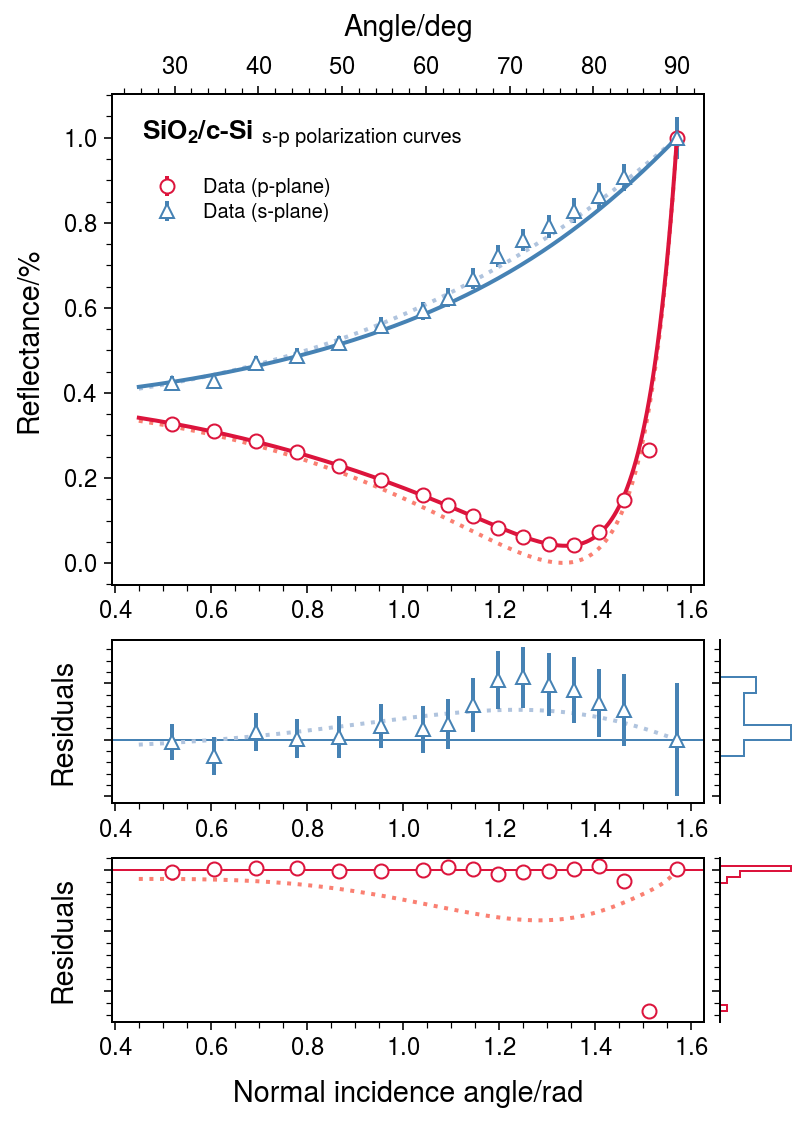

In [160]:
s_color = 'steelblue'
p_color = 'crimson'
markersize=7

fig = plt.figure(figsize=(6,8))
grid = fig.add_gridspec(3, 2, height_ratios=[3,1,1], width_ratios=[8,1], wspace=0.05)

plt.subplot(grid[0,0])

p_Si.plot(marker='o', markersize=markersize, color=p_color)
s_Si.plot(marker='^', markersize=markersize, color=s_color)

plt.plot(angles, Si_Rs(angles, n_Air, n_SiO2, n_Si+k_Si*1j, 2, 0), color='lightsteelblue', ls=':')
plt.plot(angles, Si_Rp(angles, n_Air, n_SiO2, n_Si+k_Si*1j, 2, 0), color='salmon', ls=':')
plt.xlabel('')

hep.label.exp_text('$\mathbf{SiO_2}$/c-Si ', 's-p polarization curves', loc=1)

ax = plt.gca().secondary_xaxis('top', functions=(np.rad2deg, np.deg2rad))
ax.set_xlabel('Angle/deg')
plt.legend(loc=(0.025, 0.7))

CLs_plot(CommRRC2MM, model_Rp, angles, parameters, color=p_color)
CLs_plot(CommRRC2MM, model_Rs, angles, parameters, color=s_color)


ax1 = fig.add_subplot(grid[1,0], sharex=plt.gca())

ax1.axhline(0, color=s_color, lw=1)
ax1.plot(angles, res_RS_TH, color='lightsteelblue', ls=':')
ax1.errorbar(s_Si.angles, res_RS_DP, s_Si.reflectance_std, color=s_color, fmt='^', markersize=markersize, mfc='w')
ax1.set_ylabel('Residuals')

ax3 = fig.add_subplot(grid[1,1], sharey=ax1)
hep.histplot(res_RSH, yerr=False, ax=ax3, color=s_color, orientation='horizontal')
ax3.set_yticklabels([])
ax3.set_xticks([])
ax3.set_xlabel('')

ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax2 = fig.add_subplot(grid[2,0], sharex=ax1)

ax2.axhline(0, color=p_color, lw=1)
ax2.plot(angles, res_RP_TH, color='salmon', ls=':')
ax2.errorbar(p_Si.angles, res_RP_DP, p_Si.reflectance_std, color=p_color, fmt='o', markersize=markersize, mfc='w')

ax2.set_ylabel('Residuals')
ax2.set_xlabel('Normal incidence angle/rad')


ax4 = fig.add_subplot(grid[2,1], sharey=ax2)
hep.histplot(res_RPH, yerr=False, ax=ax4, color=p_color, orientation='horizontal')
ax4.set_yticklabels([])
ax4.set_xticks([])
ax4.set_xlabel('')

ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['right'].set_visible(False)


plt.savefig('../figures/Si_Rs_Rp.pdf', bbox_inches='tight')

## Fit separati

Eseguo fit indipendenti su ciascun set di dati, minimizzando separatamente $\chi^2_{R_s}$ e $\chi^2_{R_p}$, e poi considero la propagazione sia sulle curve rispettive che sull'opposto, nei plot successivi

### Fit $\chi^2_{R_p}$

In [161]:
fcn = LeastSquares(p_Si.angles, p_Si.reflectance, p_Si.reflectance_std*(1.5), model_Rp)
m_Rp = Minuit(fcn, parameters)

m_Rp.fixed[0] = True
m_Rp.fixed[1] = True
# m_Rp.fixed[2] = True
m_Rp.fixed[3] = True
# m_Rp.fixed[4] = True
# m_Rp.fixed[5] = True

# m_Rp.fixed[7] = True

In [162]:
m_Rp.migrad()
m_Rp.hesse()
m_Rp.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1663 (chi2/ndof = 138.6)   │             Nfcn = 1181              │
│ EDM = 1.54e-05 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 1 │ x1   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ x2   │  1.01498  │  0.00012  │            │            │         │         │       │
│ 3 │ x3   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 4 │ x4   │  4.0825   │  0.0029   │            │            │         │         │       │
│ 5 │ x5   │   0.850   │   0.007   │            │            │         │         │       │
│ 6 │ x6   │   202.6   │    1.4    │            │            │         │         │       │
│ 7 │ x7   │  0.05e-3  │  0.04e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7 │
├────┼─────────────────────────────────────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0         0         0         0 │
│ x1 │         0         0         0         0         0         0         0         0 │
│ x2 │         0         0  1.46e-08         0  2.48e-07 -6.61e-07 -0.000116 -3.82e-10 │
│ x3 │         0         0         0         0         0         0         0         0 │
│ x4 │         0         0  2.48e-07         0  8.59e-06    -2e-05 -0.000616 -2.33e-08 │
│ x5 │         0         0 -6.61e-07         0    -2e-05     5e-05   0.00168  3.91e-08 │
│ x6 │         0         0 -0.000116         0 -0.000616   0.00168      1.91 -2.29e-06 │
│ x7 │         0         0 -3.82e-10         0 -2.33e-08  3.91e-08 -2.29e-06  1.39e-09 │
└────┴─────────────────────────────────────────────────────────────────────────────────┘

### Fit $\chi^2_{R_s}$

In [163]:
fcn = LeastSquares(s_Si.angles, s_Si.reflectance, s_Si.reflectance_std, model_Rs)
m_Rs = Minuit(fcn, parameters)

m_Rs.fixed[0] = True
m_Rs.fixed[1] = True
# m_Rs.fixed[2] = True
m_Rs.fixed[3] = True
# m_Rs.fixed[4] = True
# m_Rs.fixed[5] = True

# m_Rs.fixed[7] = True

In [164]:
m_Rs.migrad()
m_Rs.hesse()
m_Rs.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.433 (chi2/ndof = 0.3)    │              Nfcn = 800              │
│ EDM = 5.9e-05 (Goal: 0.0002)     │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 1 │ x1   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ x2   │     0     │   0.2e3   │            │            │         │         │       │
│ 3 │ x3   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 4 │ x4   │    4.0    │    0.4    │            │            │         │         │       │
│ 5 │ x5   │    -0     │    12     │            │            │         │         │       │
│ 6 │ x6   │    10     │    60     │            │            │         │         │       │
│ 7 │ x7   │  -0.024   │   0.016   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────┐
│    │       x0       x1       x2       x3       x4       x5       x6       x7 │
├────┼─────────────────────────────────────────────────────────────────────────┤
│ x0 │        0        0        0        0        0        0        0        0 │
│ x1 │        0        0        0        0        0        0        0        0 │
│ x2 │        0        0 3.84e+04        0     64.7 1.76e+03 1.01e+04     -1.3 │
│ x3 │        0        0        0        0        0        0        0        0 │
│ x4 │        0        0     64.7        0    0.139     2.52     14.2 -0.00173 │
│ x5 │        0        0 1.76e+03        0     2.52      136      369  -0.0508 │
│ x6 │        0        0 1.01e+04        0     14.2      369 3.56e+03   -0.284 │
│ x7 │        0        0     -1.3        0 -0.00173  -0.0508   -0.284 0.000246 │
└────┴─────────────────────────────────────────────────────────────────────────┘

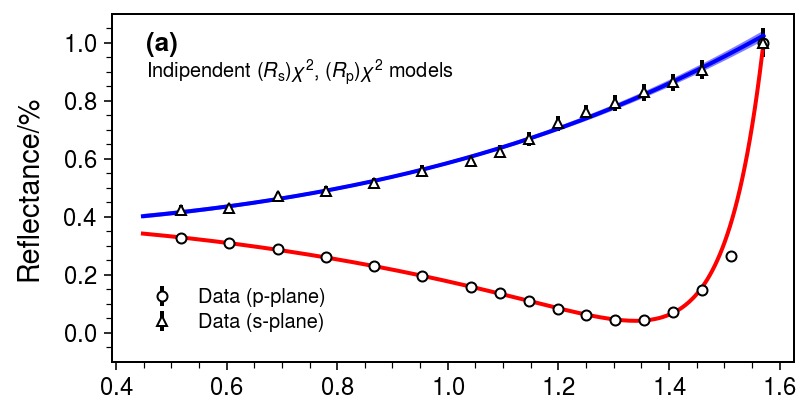

In [165]:
plt.figure(figsize=(6,3))

p_Si.plot(marker='o')
s_Si.plot(marker='^')
plt.xlabel('')
plt.ylim(-0.1, 1.1)

CLs_plot(m_Rp, model_Rp, angles, parameters, color='r')
CLs_plot(m_Rs, model_Rs, angles, parameters, color='b')
hep.label.exp_text('(a)', 'Indipendent $(R_\mathrm{s})\chi^2$, $(R_\mathrm{p})\chi^2$ models', loc=2)
plt.legend(loc=3)
plt.savefig('../figures/Si_Ind_RsChi2_RpChi2.pdf', bbox_inches='tight')

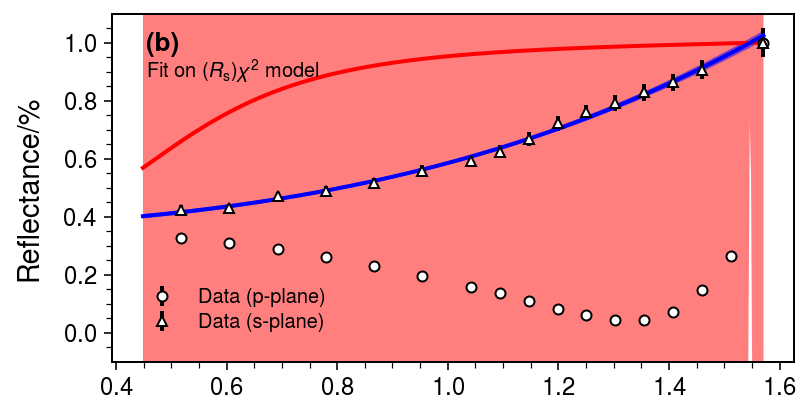

In [166]:
plt.figure(figsize=(6,3))

p_Si.plot(marker='o')
s_Si.plot(marker='^')
plt.xlabel('')
plt.ylim(-0.1, 1.1)

CLs_plot(m_Rs, model_Rp, angles, parameters, color='r')
CLs_plot(m_Rs, model_Rs, angles, parameters, color='b')
hep.label.exp_text('(b)', 'Fit on $(R_\mathrm{s})\chi^2$ model', loc=2)
plt.legend(loc=3)
plt.savefig('../figures/Si_Both_RsChi2.pdf', bbox_inches='tight')

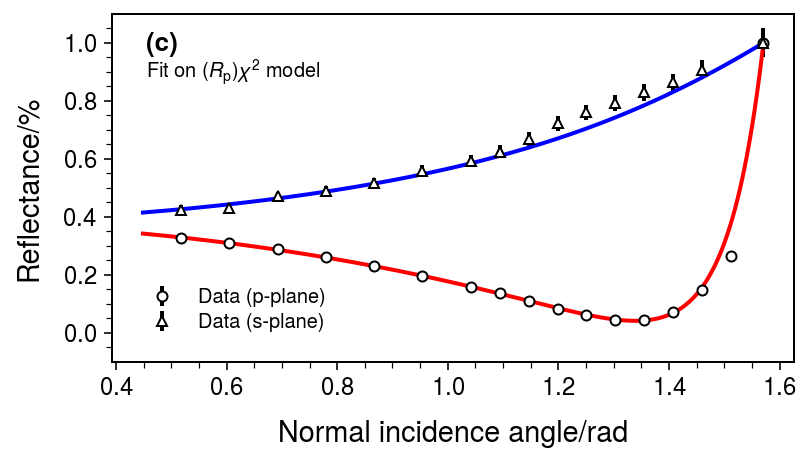

In [167]:
plt.figure(figsize=(6,3))


p_Si.plot(marker='o')
s_Si.plot(marker='^')
plt.ylim(-0.1, 1.1)

CLs_plot(m_Rp, model_Rp, angles, parameters, color='r')
CLs_plot(m_Rp, model_Rs, angles, parameters, color='b')
hep.label.exp_text('(c)', 'Fit on $(R_\mathrm{p})\chi^2$ model', loc=2)
plt.legend(loc=3)
plt.savefig('../figures/Si_Both_RpChi2.pdf', bbox_inches='tight')

Osserviamo che sull'ultimo valore abbiamo un leggero shift del grafico rispetto alla previsione. 

Posso allora correggere l'errore e ottenere in questo caso una sensata sovrastima dell'errore.

In [168]:
s_Si.reflectance_std += error_RS_scale
p_Si.reflectance_std += error_RP_scale

In [215]:
def p_plot(RsM: Minuit, RpM: Minuit, RRM: Minuit, names: dict, th_values: dict, plot_fixed=True, plot_inset=True):
    
    s_color = 'steelblue'
    p_color = 'crimson'
    
    if plot_fixed:
        N = np.count_nonzero(~RRM.fixed)
    else:
        N = RRM.npar
    
    fig, axs = plt.subplots(N, 1, figsize=(4.0, 1.65 * N))
    fig.tight_layout()
    
    RsMData = np.array([RsM.values, RsM.errors]).T
    RpMData = np.array([RpM.values, RpM.errors]).T
    RRMData = np.array([RRM.values, RRM.errors]).T
    
    j=0
    
    for i, (Rs, Rp, RR, name_key) in enumerate(zip(RsMData, RpMData, RRMData, names.keys())):
        if plot_fixed:
            if RRM.fixed[i]:
                continue
            else:
                pass
        else:
            pass
        
        axs[j].errorbar(y= 0.1, x=Rs[0], xerr=Rs[1], color=s_color, ecolor=s_color, fmt='o', mfc='w', 
                        label=f'$\mathrm{{R_s}}\chi^2, \quad{ufloat(Rs[0], Rs[1]):uSL}$')
        axs[j].errorbar(y= 0.1, x=Rs[0], xerr=3 * Rs[1], color=s_color, fmt='.', elinewidth=8, ecolor=mpl.colors.to_rgba(s_color, 0.5), zorder=1)
        
        axs[j].errorbar(y= 0.,  x=Rp[0], xerr=Rp[1], color=p_color, ecolor=p_color, fmt='o', mfc='w', 
                        label=f'$\mathrm{{R_p}}\chi^2, \quad{ufloat(Rp[0], Rp[1]):uSL}$')
        axs[j].errorbar(y= 0.,  x=Rp[0], xerr=3 * Rp[1], color=p_color, fmt='.', elinewidth=8, ecolor=mpl.colors.to_rgba(p_color, 0.5), zorder=1)
        
        axs[j].errorbar(y=-0.1, x=RR[0], xerr=RR[1], color='k', ecolor='k', fmt='o', mfc='w', 
                        label=f'$\mathrm{{(R_s+R_p)}}\chi^2, \quad{ufloat(RR[0], RR[1]):uSL}$')
        axs[j].errorbar(y=-0.1, x=RR[0], xerr=3 * RR[1], color='k', fmt='.', elinewidth=8, ecolor=mpl.colors.to_rgba('k', 0.5), zorder=1)
        
        axs[j].set_ylim(-0.2, 0.2)
        axs[j].set_yticks(ticks=[0.], labels=[f'${names[name_key]}$'])
        # axs[j].axvline(th_values[name_key], color='k', ls=':', lw='1')
        axs[j].legend(loc=(1.,0), title=f'NIST value ${th_values[name_key]}$')
        
        if plot_inset:
        
            iax = axs[j].inset_axes([0.05, 0.25, 0.4, 0.4])
            iax.errorbar(y= 0.,  x=Rp[0], xerr=Rp[1], color=p_color, ecolor=p_color, fmt='o', mfc='w', 
                         label=f'$\mathrm{{R_p}}\chi^2, \quad{ufloat(Rp[0], Rp[1]):uSL}$')
            iax.errorbar(y= 0.,  x=Rp[0], xerr=3 * Rp[1], color=p_color, fmt='.', elinewidth=8, ecolor=mpl.colors.to_rgba(p_color, 0.5), zorder=1)
            
            iax.errorbar(y=-0.1, x=RR[0], xerr=RR[1], color='k', ecolor='k', fmt='o', mfc='w', 
                         label=f'$\mathrm{{(R_s+R_p)}}\chi^2, \quad{ufloat(RR[0], RR[1]):uSL}$')
            iax.errorbar(y=-0.1, x=RR[0], xerr=3 * RR[1], color='k', fmt='.', elinewidth=8, ecolor=mpl.colors.to_rgba('k', 0.5), zorder=1)
            
            iax.xaxis.set_major_locator(plt.MaxNLocator(2))
            iax.set_ylim(-0.15, 0.05)
            iax.set_yticks([])
            
            axs[j].indicate_inset_zoom(iax,edgecolor='k')
        
        j += 1


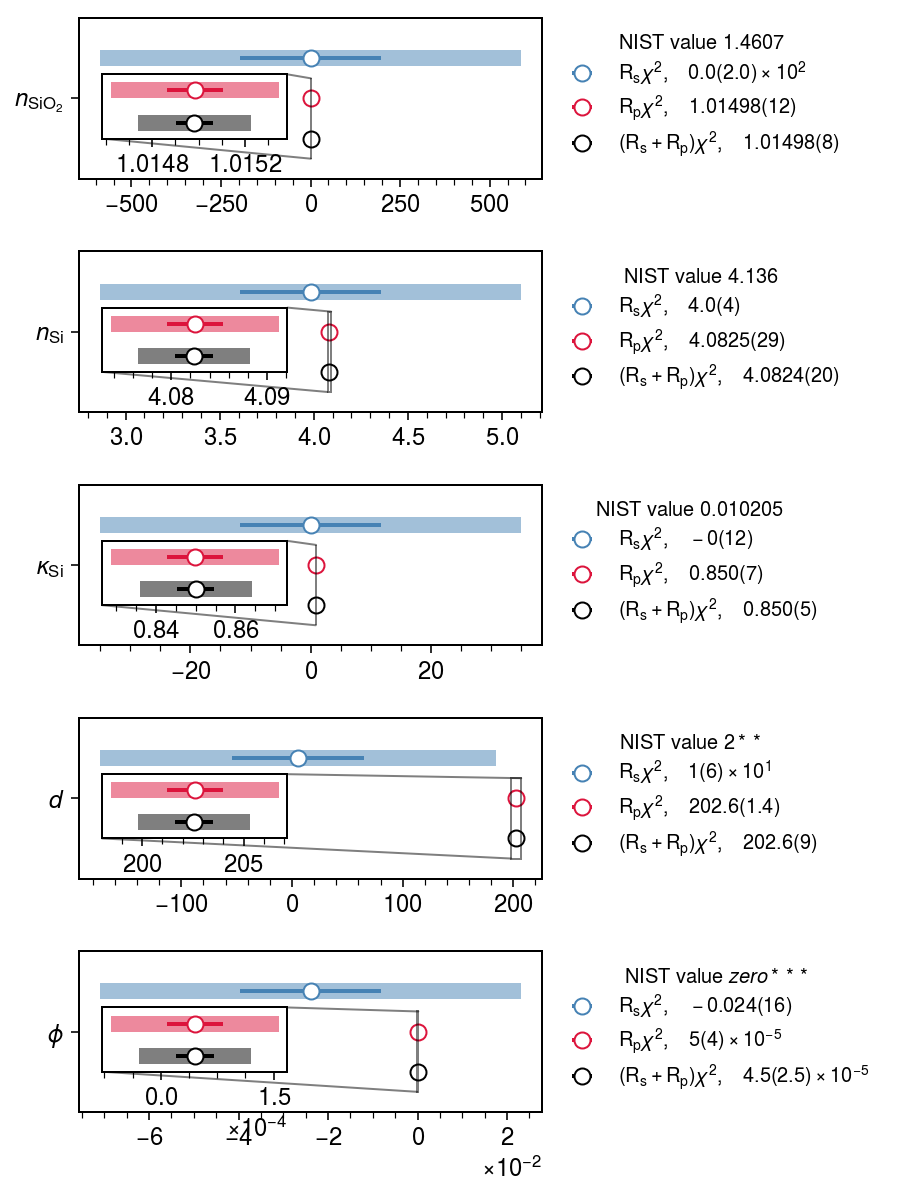

In [216]:
from uncertainties import ufloat

names = {
    'nAir': 'n_\mathrm{Air}',
    'kAir': '\kappa_\mathrm{Air}',
    'nSiO2': 'n_\mathrm{SiO_2}',
    'kSiO2': '\kappa_\mathrm{SiO_2}',
    'nSi': 'n_\mathrm{Si}',
    'kSi': '\kappa_\mathrm{Si}',
    'layer': 'd',
    'phase': '\phi'
}

th_val = {
    'nAir':  1.00027821,
    'kAir': 'zero*',
    'nSiO2': 1.4607,
    'kSiO2': 'zero*',
    'nSi': 4.1360,
    'kSi': 0.010205,
    'layer': '2**',
    'phase': 'zero***'
}

p_plot(m_Rs, m_Rp, CommRRC2MM, names, th_val)
plt.savefig('../figures/Si_results_all.pdf', bbox_inches='tight')


**TODO: inste axes in previous figure just to show last two models**

In [217]:




CommRRChi2_rescaled = (
    LeastSquares(s_Si.angles, s_Si.reflectance, s_Si.reflectance_std, model=model_Rs) + 
    LeastSquares(p_Si.angles, p_Si.reflectance, p_Si.reflectance_std, model=model_Rp)
)

CommRRC2MM_rescaled = Minuit(CommRRChi2_rescaled, parameters)

# Fixing Air values
CommRRC2MM_rescaled.fixed[0] = True
CommRRC2MM_rescaled.fixed[1] = True

CommRRC2MM_rescaled.fixed[3] = True

CommRRC2MM_rescaled.migrad()
CommRRC2MM_rescaled.hesse()
CommRRC2MM_rescaled.migrad()




┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.989 (chi2/ndof = 0.3)    │             Nfcn = 1110              │
│ EDM = 7.23e-09 (Goal: 0.0002)    │            time = 0.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 1 │ x1   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ x2   │   1.77    │   0.23    │            │            │         │         │       │
│ 3 │ x3   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 4 │ x4   │   0.99    │   0.27    │            │            │         │         │       │
│ 5 │ x5   │   -1.1    │    0.5    │            │            │         │         │       │
│ 6 │ x6   │    72     │    13     │            │            │         │         │       │
│ 7 │ x7   │  0.0008   │  0.0017   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7 │
├────┼─────────────────────────────────────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0         0         0         0 │
│ x1 │         0         0         0         0         0         0         0         0 │
│ x2 │         0         0    0.0509         0   -0.0279    0.0922      0.92  7.11e-05 │
│ x3 │         0         0         0         0         0         0         0         0 │
│ x4 │         0         0   -0.0279         0      0.07    -0.126     -3.32  5.85e-05 │
│ x5 │         0         0    0.0922         0    -0.126     0.273      5.56 -5.74e-06 │
│ x6 │         0         0      0.92         0     -3.32      5.56       164  -0.00327 │
│ x7 │         0         0  7.11e-05         0  5.85e-05 -5.74e-06  -0.00327  2.88e-06 │
└────┴─────────────────────────────────────────────────────────────────────────────────┘

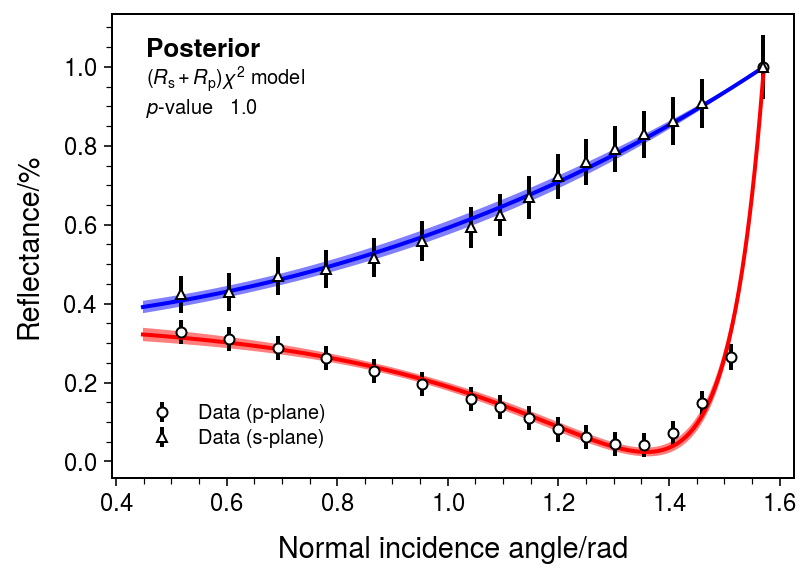

In [218]:
import ROOT
from scipy import stats

p_Si.plot(marker='o')
s_Si.plot(marker='^')

CLs_plot(CommRRC2MM_rescaled, model_Rp, angles, parameters, color='r')
CLs_plot(CommRRC2MM_rescaled, model_Rs, angles, parameters, color='b')

p=1 - stats.chi2.cdf(CommRRC2MM_rescaled.fmin.fval, CommRRC2MM_rescaled.ndof)

hep.label.exp_text('Posterior', f'$(R_\mathrm{{s}} + R_\mathrm{{p}})\chi^2$ model\n$p$-value$\quad{p:.3}$', loc=2)
plt.legend(loc=3)
plt.savefig('../figures/Si_rescaled_fit.pdf', bbox_inches='tight')